# 1. Import

In [1]:
import os
import cv2
import io
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, initializers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.activations import swish

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from PIL import Image
from random import randint
from IPython.display import clear_output


# 2. Préparation des Données

In [2]:

#Code de récupération du jeu de données depuis Kaggle
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/MyTokenKarim.json
print("Configuration de l'API Kaggle terminée.")

print("Téléchargement du dataset GTSRB en cours...")
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

if not os.path.exists("gtsrb-german-traffic-sign.zip"):
    print("Erreur : le fichier ZIP du dataset n'a pas été téléchargé correctement.")
else:
    print("Dataset téléchargé avec succès.")

    print("Décompression des fichiers...")
    !unzip -q gtsrb-german-traffic-sign.zip -d gtsrb_data

    print("Liste des fichiers extraits :")
    !ls gtsrb_data



mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/MyTokenKarim.json': No such file or directory
Configuration de l'API Kaggle terminée.
Téléchargement du dataset GTSRB en cours...
Dataset URL: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
License(s): CC0-1.0
 99% 608M/612M [00:09<00:00, 75.1MB/s]
100% 612M/612M [00:09<00:00, 68.9MB/s]
Dataset téléchargé avec succès.
Décompression des fichiers...
Liste des fichiers extraits :
meta  Meta  Meta.csv  test  Test  Test.csv  train  Train  Train.csv


Nombre de classes détectées : 43
Exemple de classes : ['0', '1', '10', '11', '12']


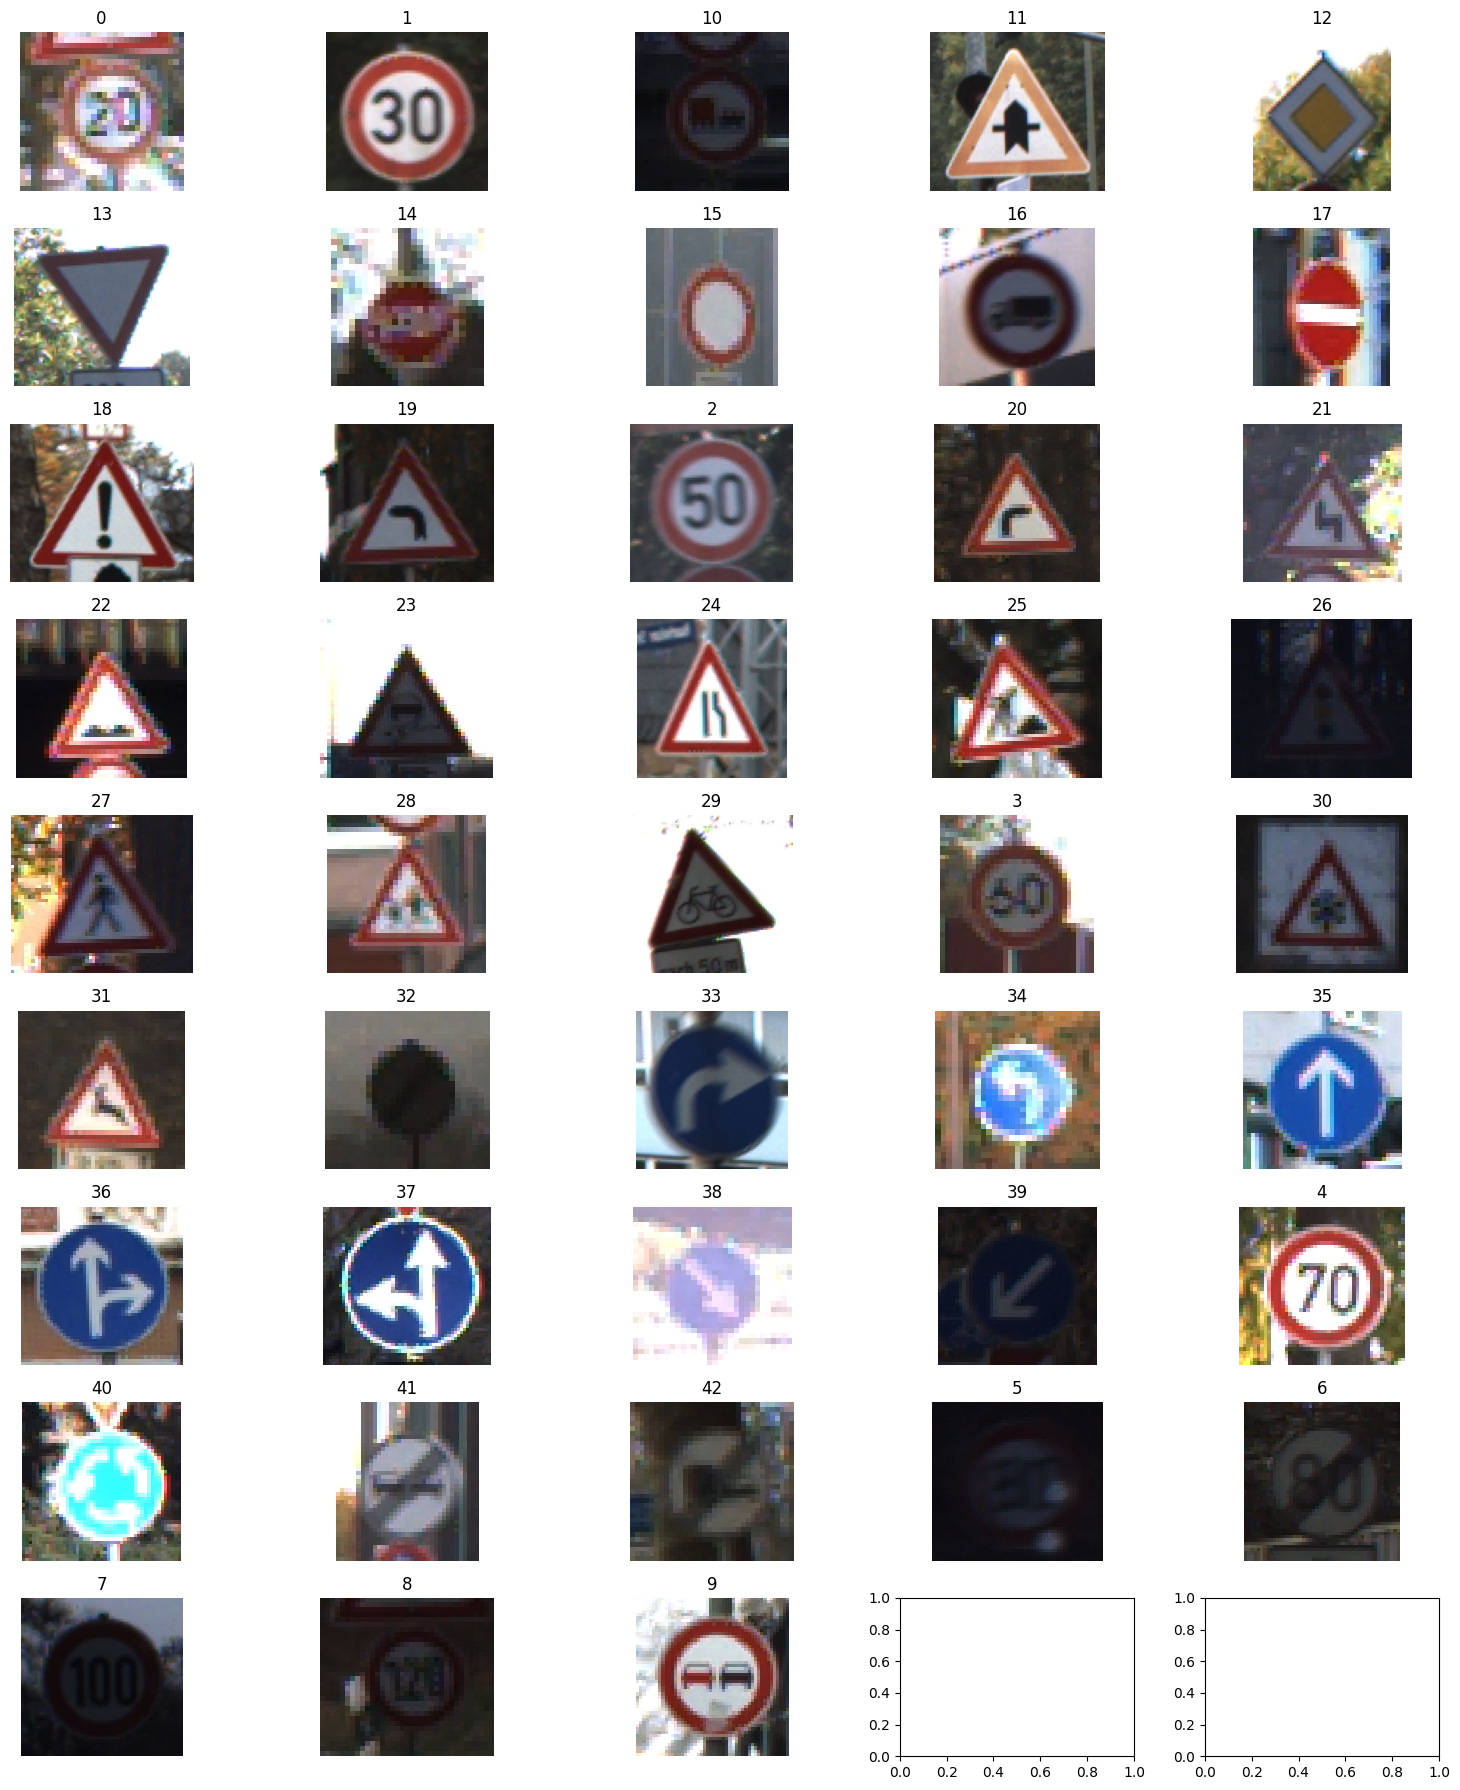

In [3]:
#Code d'affichage d'une image pour chaque classe
dataset_path = "gtsrb_data/Train"


classes = sorted(os.listdir(dataset_path))
num_classes = len(classes)
print(f"Nombre de classes détectées : {num_classes}")
print(f"Exemple de classes : {classes[:5]}")


fig, axes = plt.subplots(9, 5, figsize=(15, 18))
axes = axes.flatten()

for i, class_name in enumerate(classes[:43]):
    class_path = os.path.join(dataset_path, class_name)


    if len(os.listdir(class_path)) > 0:
        image_path = os.path.join(class_path, os.listdir(class_path)[0])  # Première image de chaque classe
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axes[i].imshow(image)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    else:
        axes[i].axis("off")

plt.tight_layout()
plt.show()


Affichage de la forme du DataFrame
(39209, 2)
Affichage de la description du DataFrame
                                      image_path class_label
count                                      39209       39209
unique                                     39209          43
top     gtsrb_data/Train/0/00000_00001_00002.png           2
freq                                           1        2250
Affichage du DataFrame
                                     image_path class_label
0      gtsrb_data/Train/0/00000_00001_00002.png           0
1      gtsrb_data/Train/0/00000_00003_00029.png           0
2      gtsrb_data/Train/0/00000_00003_00001.png           0
3      gtsrb_data/Train/0/00000_00004_00025.png           0
4      gtsrb_data/Train/0/00000_00005_00020.png           0
...                                         ...         ...
39204  gtsrb_data/Train/9/00009_00048_00002.png           9
39205  gtsrb_data/Train/9/00009_00020_00010.png           9
39206  gtsrb_data/Train/9/00009_00020_00008.p

<ipython-input-4-177bc060ba56>:38: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  class_counts = pd.value_counts(df['class_label'])


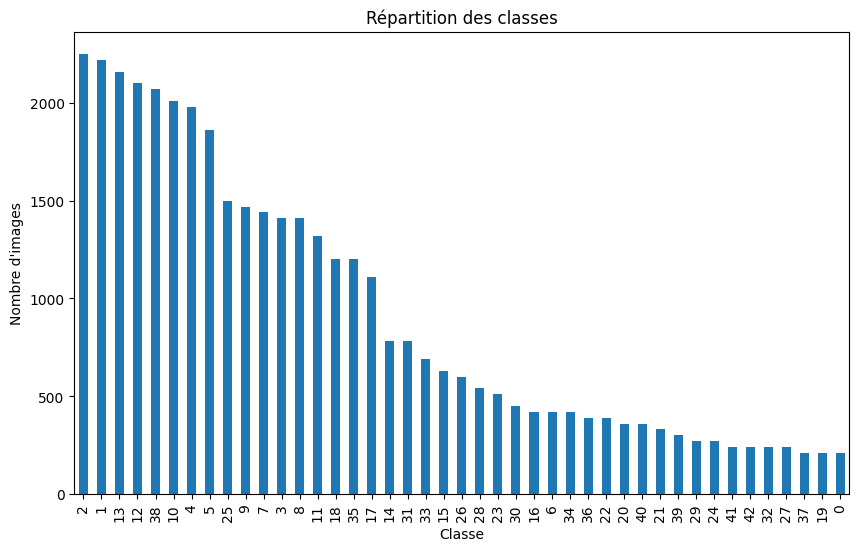

In [4]:

# Code d'affichage de la description du Dataframme
dataset_path = "gtsrb_data/Train"

classes = sorted(os.listdir(dataset_path))

# liste pour stocker les chemins des images et leurs classes
image_paths = []
class_labels = []

for class_name in classes[:43]:
    class_path = os.path.join(dataset_path, class_name)


    for image_filename in os.listdir(class_path):
        image_path = os.path.join(class_path, image_filename)
        image_paths.append(image_path)
        class_labels.append(class_name)


df = pd.DataFrame({
    'image_path': image_paths,
    'class_label': class_labels
})


print("Affichage de la forme du DataFrame")
print(df.shape)


print("Affichage de la description du DataFrame")
print(df.describe())


print("Affichage du DataFrame")
print(df)


class_counts = pd.value_counts(df['class_label'])

# Répartition des classes
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title("Répartition des classes")
plt.xlabel("Classe")
plt.ylabel("Nombre d'images")
plt.show()

In [5]:
#Code de préparation et d'augmentation des images pour le traitement dans les modèles

def data_create() :
    dataset_path = "gtsrb_data/Train"


    classes = sorted(os.listdir(dataset_path))

    # Listes pour stocker les chemins des images et leurs labels
    image_paths = []
    class_labels = []


    for class_name in classes[:43]:
        class_path = os.path.join(dataset_path, class_name)
        for image_filename in os.listdir(class_path):
            image_path = os.path.join(class_path, image_filename)
            image_paths.append(image_path)
            class_labels.append(class_name)


    df = pd.DataFrame({
        'image_path': image_paths,
        'class_label': class_labels
    })

    # Fonction pour charger et prétraiter les images
    def load_and_preprocess_images(image_paths):
        images = []
        for image_path in image_paths:
            image = cv2.imread(image_path)
            if image is None:
                print(f"Erreur de lecture de l'image: {image_path}")
                continue

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (32, 32))
            image = image.astype('float32') / 255.0
            images.append(image)

        return np.array(images)


    X = load_and_preprocess_images(df['image_path'].values)

    # Forme des images
    print(f"Forme de X (données images) : {X.shape}")

    # Encodage des labels
    encoder = LabelEncoder()
    Y = encoder.fit_transform(df['class_label'].values)
    Y = to_categorical(Y, num_classes=43)


    print(f"Exemple de labels encodés : {Y[:10]}")

    # Séparation des données
    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2, random_state=42, stratify=Y
    )


    print(f"Forme de X_train : {X_train.shape}")
    print(f"Forme de X_test : {X_test.shape}")
    print(f"Forme de Y_train : {Y_train.shape}")
    print(f"Forme de Y_test : {Y_test.shape}")

    # Augmentation des données
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Augmentation des données d'entraînement
    datagen.fit(X_train)
    return X_train, X_test, Y_train, Y_test

# 3. Conception et Implémentation du Modèle CNN

# 3.1 Modèle simple


Forme de X (données images) : (39209, 32, 32, 3)
Exemple de labels encodés : [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

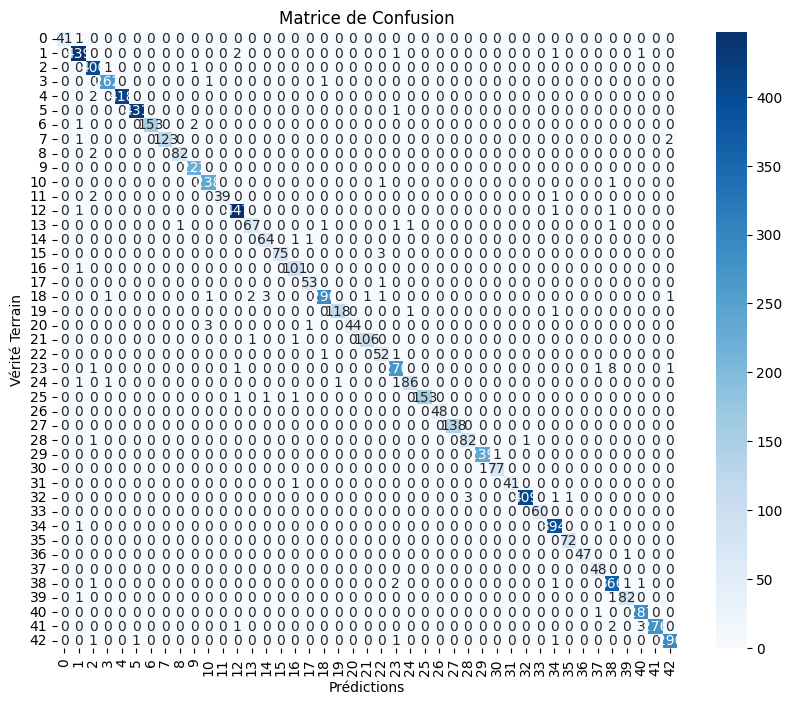

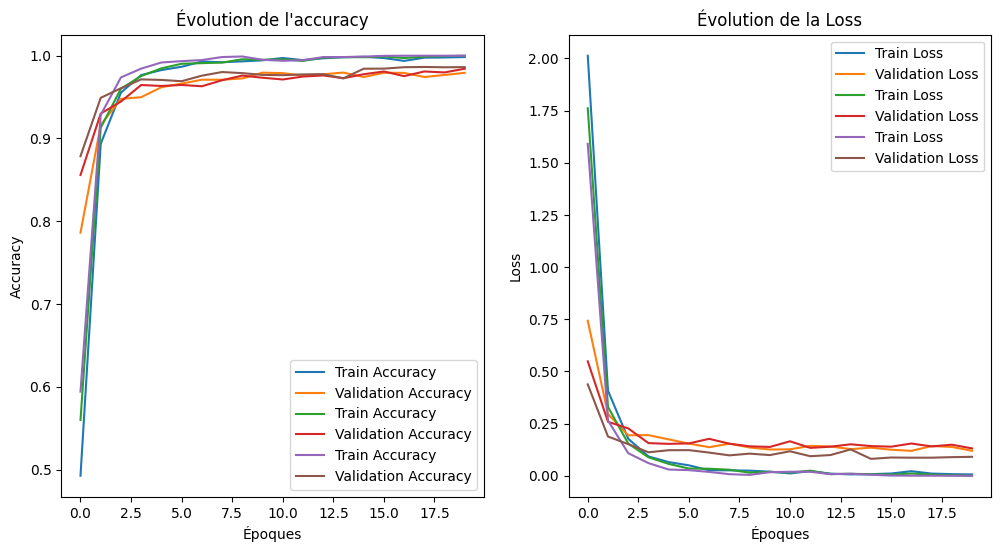

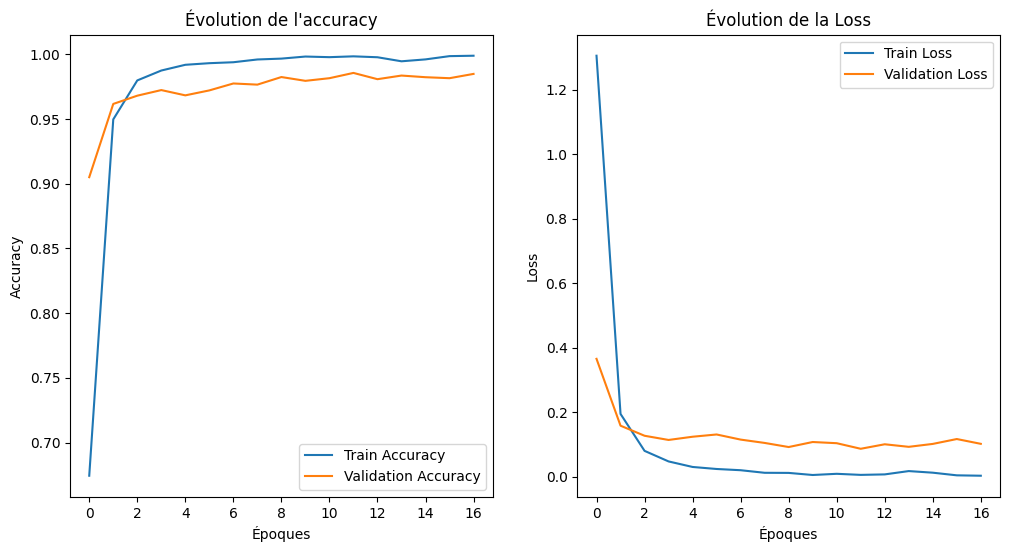

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9876 - loss: 0.0710
Loss sur le test : 0.0870
Accuracy sur le test : 98.57%


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 26, 26, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │       2,768,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 43)                  │           2,795 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,484,227 (32.36 MB)

 Trainable params: 2,828,075 (10.79 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,656,152 (21.58 MB)

In [6]:
# Modèle pour étalonner les paramètres à l'aide d'un grid-search



def create_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(32, 32, 3)))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(43, activation='softmax'))
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model
X_train, X_test, Y_train, Y_test = data_create()

# Validation croisée
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_results = []
train_histories = []

for train_index, val_index in kfold.split(X_train, np.argmax(Y_train, axis=1)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]

    model= create_model()
    history = model.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=20, batch_size=256, verbose=1)
    train_histories.append(history.history)

    Y_val_pred = model.predict(X_val_fold)
    val_accuracy = accuracy_score(np.argmax(Y_val_fold, axis=1), np.argmax(Y_val_pred, axis=1))
    cv_results.append(val_accuracy)

print(f"Précision moyenne en validation croisée : {np.mean(cv_results) * 100:.2f}%")
print(f"Écart-type de la précision : {np.std(cv_results) * 100:.2f}%")

# Création du modèle final
model = create_model()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


history_final = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=40,
    batch_size=256,
    verbose=1,
    callbacks=[early_stopping]
)

# Prédictions
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

test_accuracy = accuracy_score(Y_true, Y_pred_classes)
print(f"Précision sur le jeu de test : {test_accuracy * 100:.2f}%")

# Matrice de confusion
cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérité Terrain")
plt.show()

# Affichages des courbes de performances
def plot_history(histories):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    for history in histories:
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title("Évolution de l'accuracy")
    plt.xlabel("Époques")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    for history in histories:
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title("Évolution de la Loss")
    plt.xlabel("Époques")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_history(train_histories)
plot_history([history_final.history])
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=1)
print(f"Loss sur le test : {test_loss:.4f}")
print(f"Accuracy sur le test : {test_acc * 100:.2f}%")
model.summary()

model.save("model.h5")


## 3.2 Modèle affiné

In [7]:
# Définition du modèle CNN avec activation ReLU basé sur le modèle précédent. Ajout de complexité dans le modèle pour de meilleurs performances
def create_model_relu():
    model_relu = models.Sequential()


    model_relu.add(layers.Conv2D(32, (3, 3), activation='relu',
                                  kernel_initializer=initializers.HeNormal(),
                                  input_shape=(32, 32, 3)))
    model_relu.add(layers.BatchNormalization())
    model_relu.add(layers.MaxPooling2D((2, 2)))
    model_relu.add(layers.Dropout(0.25))


    model_relu.add(layers.Conv2D(64, (3, 3), activation='relu',
                                  kernel_initializer=initializers.HeNormal()))
    model_relu.add(layers.BatchNormalization())
    model_relu.add(layers.MaxPooling2D((2, 2)))
    model_relu.add(layers.Dropout(0.25))

    model_relu.add(layers.Conv2D(128, (3, 3), activation='relu',
                                  kernel_initializer=initializers.HeNormal()))
    model_relu.add(layers.BatchNormalization())
    model_relu.add(layers.MaxPooling2D((2, 2)))
    model_relu.add(layers.Dropout(0.25))

    model_relu.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same',
                                  kernel_initializer=initializers.HeNormal()))
    model_relu.add(layers.BatchNormalization())
    model_relu.add(layers.Dropout(0.25))

    model_relu.add(layers.GlobalAveragePooling2D())

    # Couche dense
    model_relu.add(layers.Dense(256, activation='relu',
                                  kernel_initializer=initializers.HeNormal()))
    model_relu.add(layers.BatchNormalization())
    model_relu.add(layers.Dropout(0.5))

    model_relu.add(layers.Dense(43, activation='softmax'))

    model_relu.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

    return model_relu


# 4. Entraînement du Modèle

Forme de X (données images) : (39209, 32, 32, 3)
Exemple de labels encodés : [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 22s 130ms/step - accuracy: 0.1358 - loss: 3.8985 - val_accuracy: 0.1008 - val_loss: 3.3263
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4456 - loss: 1.9320 - val_accuracy: 0.2409 - val_loss: 2.7701
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6150 - loss: 1.2101 - val_accuracy: 0.4719 - val_loss: 1.8066
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7454 - loss: 0.7854 - val_accuracy: 0.6613 - val_loss: 1.1254
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8251 - loss: 0.5425 - val_accuracy: 0.9070 - val_loss: 0.3321
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8752 - loss: 0.3899 - val_accuracy: 0.9482 - val_loss: 0.1797
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9075 - loss: 0.2871 - val_accuracy: 0.9761 - val_loss: 0.0838
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9258 - loss: 0.2300 - val_accuracy: 0.9818 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 96ms/step - accuracy: 0.1475 - loss: 3.7588 - val_accuracy: 0.1274 - val_loss: 3.3988
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.4487 - loss: 1.8732 - val_accuracy: 0.2282 - val_loss: 2.8604
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6223 - loss: 1.1903 - val_accuracy: 0.3985 - val_loss: 2.0374
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7382 - loss: 0.8050 - val_accuracy: 0.6411 - val_loss: 1.1095
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8228 - loss: 0.5594 - val_accuracy: 0.8430 - val_loss: 0.4908
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8713 - loss: 0.3977 - val_accuracy: 0.9410 - val_loss: 0.1968
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8932 - loss: 0.3174 - val_accuracy: 0.9694 - val_loss: 0.1041
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9192 - loss: 0.2547 - val_accuracy: 0.9781 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 118ms/step - accuracy: 0.1708 - loss: 3.7088 - val_accuracy: 0.1516 - val_loss: 3.3244
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4934 - loss: 1.7109 - val_accuracy: 0.2655 - val_loss: 2.6229
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6687 - loss: 1.0398 - val_accuracy: 0.5371 - val_loss: 1.5361
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7875 - loss: 0.6606 - val_accuracy: 0.7104 - val_loss: 0.9362
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8457 - loss: 0.4726 - val_accuracy: 0.8568 - val_loss: 0.4411
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8883 - loss: 0.3482 - val_accuracy: 0.9511 - val_loss: 0.1682
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9193 - loss: 0.2603 - val_accuracy: 0.9679 - val_loss: 0.1043
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9294 - loss: 0.2146 - val_accuracy: 0.9819 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 19s 88ms/step - accuracy: 0.2243 - loss: 3.3364 - val_accuracy: 0.1109 - val_loss: 3.0946
Epoch 2/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6176 - loss: 1.2207 - val_accuracy: 0.5179 - val_loss: 1.6565
Epoch 3/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7920 - loss: 0.6388 - val_accuracy: 0.7675 - val_loss: 0.7736
Epoch 4/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8786 - loss: 0.3847 - val_accuracy: 0.9441 - val_loss: 0.1800
Epoch 5/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9183 - loss: 0.2582 - val_accuracy: 0.9759 - val_loss: 0.0771
Epoch 6/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9453 - loss: 0.1748 - val_accuracy: 0.9874 - val_loss: 0.0464
Epoch 7/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9572 - loss: 0.1395 - val_accuracy: 0.9920 - val_loss: 0.0304
Epoch 8/40
123/123 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9668 - loss: 0.1081 - val_acc

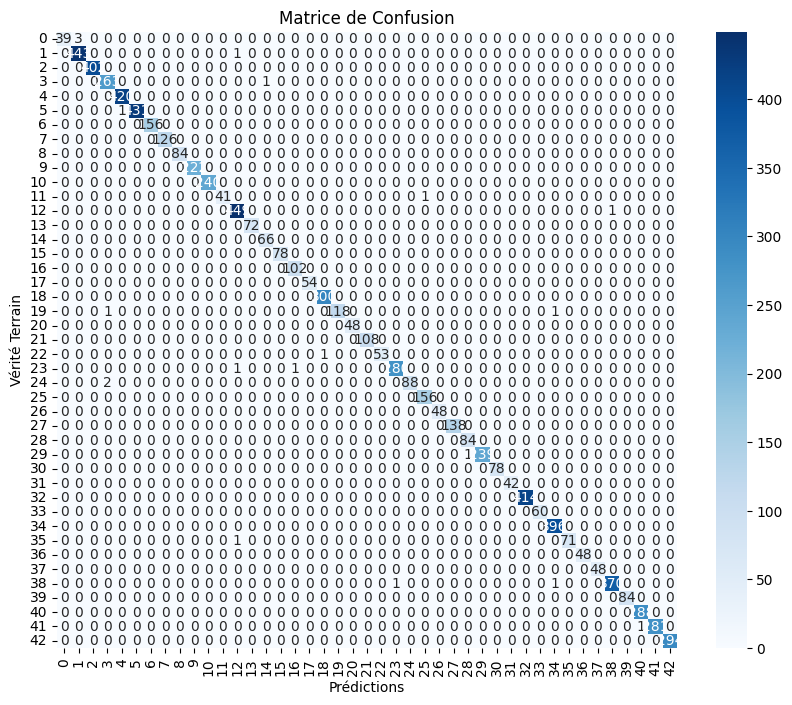

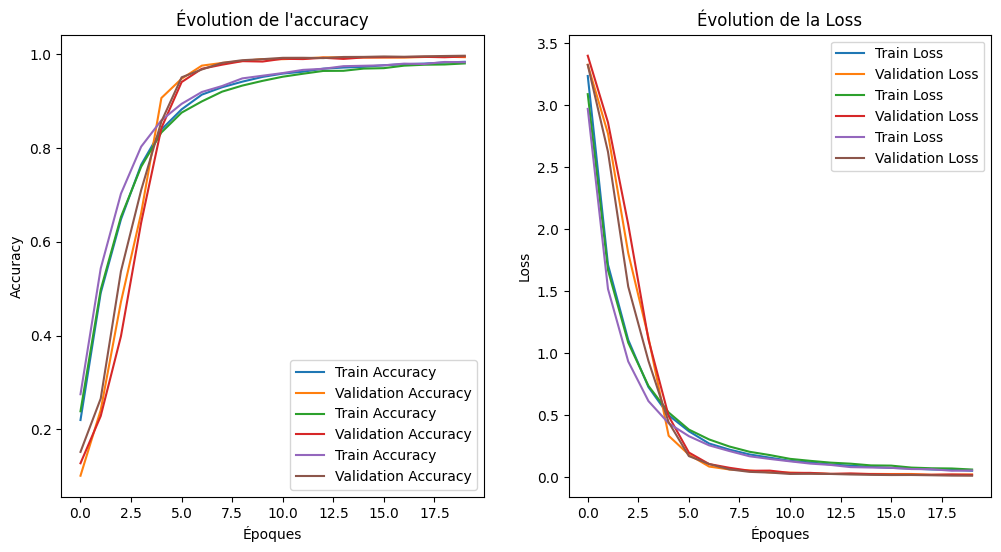

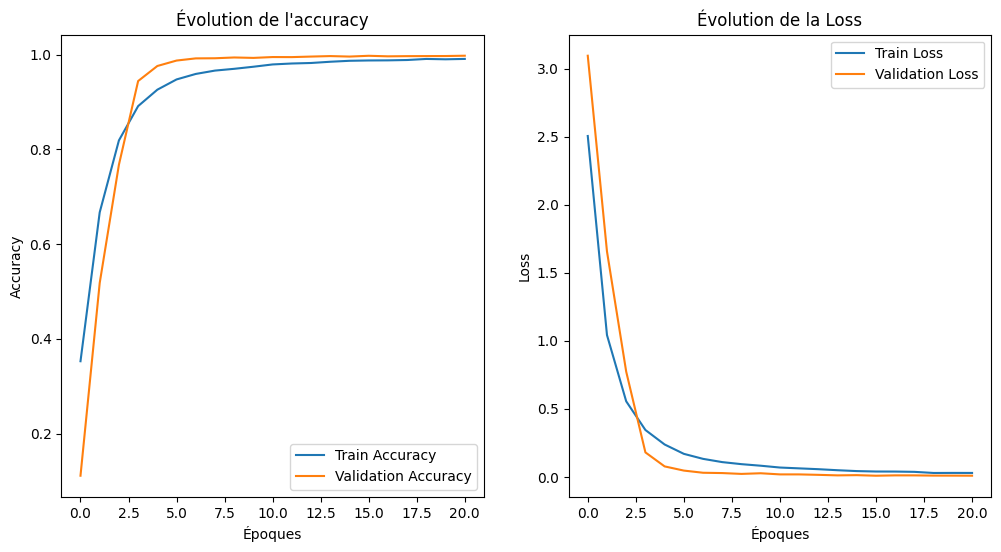

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9980 - loss: 0.0060
Loss sur le test : 0.0086
Accuracy sur le test : 99.74%


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,401,667 (5.35 MB)

 Trainable params: 466,731 (1.78 MB)

 Non-trainable params: 1,472 (5.75 KB)

 Optimizer params: 933,464 (3.56 MB)

In [8]:
X_train, X_test, Y_train, Y_test = data_create()

# Validation croisée
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_results = []
train_histories = []

for train_index, val_index in kfold.split(X_train, np.argmax(Y_train, axis=1)):
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]

    model_relu = create_model_relu()
    history = model_relu.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=20, batch_size=256, verbose=1)
    train_histories.append(history.history)

    Y_val_pred = model_relu.predict(X_val_fold)
    val_accuracy = accuracy_score(np.argmax(Y_val_fold, axis=1), np.argmax(Y_val_pred, axis=1))
    cv_results.append(val_accuracy)

print(f"Précision moyenne en validation croisée : {np.mean(cv_results) * 100:.2f}%")
print(f"Écart-type de la précision : {np.std(cv_results) * 100:.2f}%")

# Création du modèle final
model_relu = create_model_relu()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


history_final = model_relu.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=40,
    batch_size=256,
    verbose=1,
    callbacks=[early_stopping]
)

# Prédictions
Y_pred = model_relu.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

test_accuracy = accuracy_score(Y_true, Y_pred_classes)
print(f"Précision sur le jeu de test : {test_accuracy * 100:.2f}%")

# Matrice de confusion
cm = confusion_matrix(Y_true, Y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérité Terrain")
plt.show()

# Affichages des courbes de performances
def plot_history(histories):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    for history in histories:
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title("Évolution de l'accuracy")
    plt.xlabel("Époques")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    for history in histories:
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title("Évolution de la Loss")
    plt.xlabel("Époques")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

plot_history(train_histories)
plot_history([history_final.history])
test_loss, test_acc = model_relu.evaluate(X_test, Y_test, verbose=1)
print(f"Loss sur le test : {test_loss:.4f}")
print(f"Accuracy sur le test : {test_acc * 100:.2f}%")
model_relu.summary()

model_relu.save("model_relu.h5")


# 5. Évaluation du Modèle

Nombre d'images test chargées : (12630, 32, 32, 3)
Classes : ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


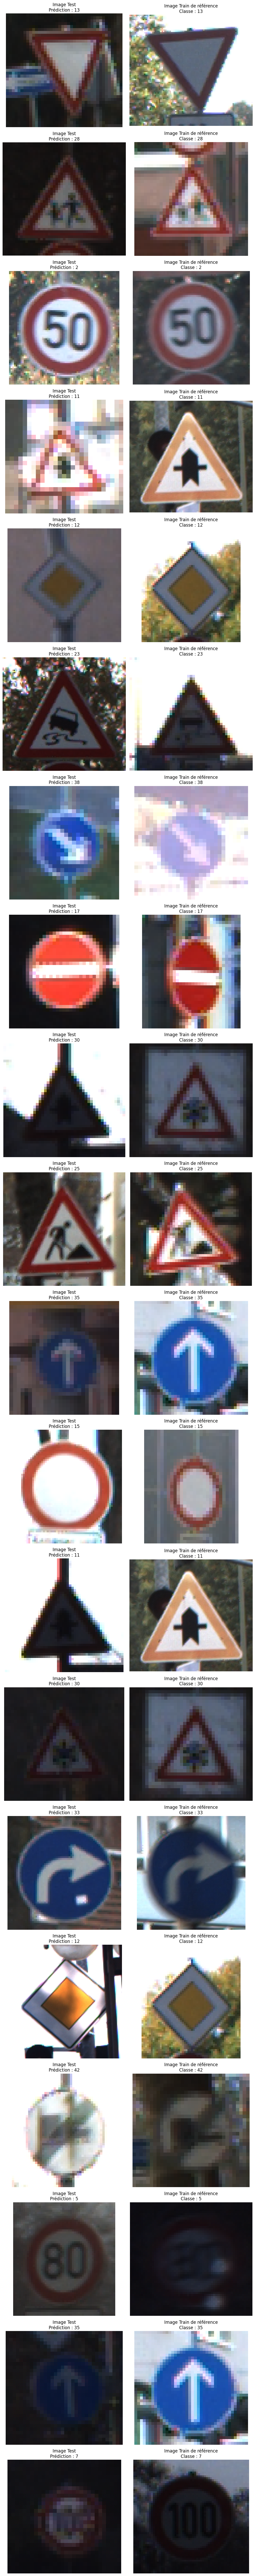

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model


test_dataset_path = "gtsrb_data/Test"   # Dossier Test contenant les images PNG
train_dataset_path = "gtsrb_data/Train" # Dossier Train organisé en sous-dossiers par classe

# Récupérer la liste des images dans Test
test_image_paths = [os.path.join(test_dataset_path, f) for f in os.listdir(test_dataset_path) if f.endswith('.png')]

# préparation des images
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Erreur de lecture :", image_path)
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (32, 32))
    image = image.astype('float32') / 255.0
    return image


X_test = []
valid_test_paths = []
for path in test_image_paths:
    img = load_and_preprocess_image(path)
    if img is not None:
        X_test.append(img)
        valid_test_paths.append(path)
X_test = np.array(X_test)

if len(X_test) == 0:
    print("Aucune image test chargée. Vérifie le chemin :", test_dataset_path)
else:
    print("Nombre d'images test chargées :", X_test.shape)

# Récupérer la liste des classes
class_names = sorted([d for d in os.listdir(train_dataset_path) if os.path.isdir(os.path.join(train_dataset_path, d))])
print("Classes :", class_names)


# Réaliser les prédictions avec model_relu
predictions = model_relu.predict(X_test)
predicted_indices = np.argmax(predictions, axis=1)
predicted_classes = [class_names[idx] for idx in predicted_indices]

# Affichage des résultats
N = min(20, len(valid_test_paths))
fig, axes = plt.subplots(N, 2, figsize=(10, 5 * N))
if N == 1:
    axes = np.expand_dims(axes, axis=0)

for i in range(N):
    test_img_orig = cv2.imread(valid_test_paths[i])
    if test_img_orig is not None:
        test_img_orig = cv2.cvtColor(test_img_orig, cv2.COLOR_BGR2RGB)
    else:
        test_img_orig = np.zeros((32, 32, 3), dtype=np.uint8)


    pred_class = predicted_classes[i]

    # Dans Train récupérer la première image de la classe prédite
    train_class_folder = os.path.join(train_dataset_path, pred_class)
    train_ref_image = None
    if os.path.isdir(train_class_folder):
        train_files = [f for f in os.listdir(train_class_folder) if f.endswith('.png')]
        if len(train_files) > 0:
            train_ref_image_path = os.path.join(train_class_folder, train_files[0])
            train_ref_image = cv2.imread(train_ref_image_path)
            if train_ref_image is not None:
                train_ref_image = cv2.cvtColor(train_ref_image, cv2.COLOR_BGR2RGB)
    if train_ref_image is None:
        train_ref_image = np.zeros((32, 32, 3), dtype=np.uint8)

    # Affichage des images
    axes[i, 0].imshow(test_img_orig)
    axes[i, 0].set_title("Image Test\nPrédiction : " + pred_class)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(train_ref_image)
    axes[i, 1].set_title("Image Train de référence\nClasse : " + pred_class)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


# 6. Améliorations et Expérimentations

## 6.1 Definition de modèle

In [10]:

# Définition du modèle CNN avec activation swish
def create_model_Swish():
    model_swish = models.Sequential()


    model_swish.add(layers.Conv2D(32, (3, 3), activation=swish,
                                  kernel_initializer=initializers.HeNormal(),
                                  input_shape=(32, 32, 3)))
    model_swish.add(layers.BatchNormalization())
    model_swish.add(layers.MaxPooling2D((2, 2)))
    model_swish.add(layers.Dropout(0.25))


    model_swish.add(layers.Conv2D(64, (3, 3), activation=swish,
                                  kernel_initializer=initializers.HeNormal()))
    model_swish.add(layers.BatchNormalization())
    model_swish.add(layers.MaxPooling2D((2, 2)))
    model_swish.add(layers.Dropout(0.25))


    model_swish.add(layers.Conv2D(128, (3, 3), activation=swish,
                                  kernel_initializer=initializers.HeNormal()))
    model_swish.add(layers.BatchNormalization())
    model_swish.add(layers.MaxPooling2D((2, 2)))
    model_swish.add(layers.Dropout(0.25))


    model_swish.add(layers.Conv2D(256, (3, 3), activation=swish, padding='same',
                                  kernel_initializer=initializers.HeNormal()))
    model_swish.add(layers.BatchNormalization())
    model_swish.add(layers.Dropout(0.25))


    model_swish.add(layers.GlobalAveragePooling2D())


    model_swish.add(layers.Dense(256, activation=swish,
                                  kernel_initializer=initializers.HeNormal()))
    model_swish.add(layers.BatchNormalization())
    model_swish.add(layers.Dropout(0.5))


    model_swish.add(layers.Dense(43, activation='softmax'))

    model_swish.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

    return model_swish



## 6.2 Entraînement du modèle

Forme de X (données images) : (39209, 32, 32, 3)
Exemple de labels encodés : [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - accuracy: 0.1618 - loss: 3.7025 - val_accuracy: 0.0600 - val_loss: 3.5397
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4561 - loss: 1.8510 - val_accuracy: 0.1827 - val_loss: 2.9226
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6314 - loss: 1.1552 - val_accuracy: 0.4146 - val_loss: 1.9420
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7549 - loss: 0.7511 - val_accuracy: 0.7014 - val_loss: 0.9624
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8314 - loss: 0.5212 - val_accuracy: 0.8812 - val_loss: 0.4229
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8814 - loss: 0.3718 - val_accuracy: 0.9322 - val_loss: 0.2392
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9145 - loss: 0.2790 - val_accuracy: 0.9583 - val_loss: 0.1516
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9315 - loss: 0.2171 - val_accuracy: 0.9712 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 116ms/step - accuracy: 0.1659 - loss: 3.7098 - val_accuracy: 0.0835 - val_loss: 3.5461
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4769 - loss: 1.7634 - val_accuracy: 0.1842 - val_loss: 2.8868
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6514 - loss: 1.1018 - val_accuracy: 0.4373 - val_loss: 1.9526
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7736 - loss: 0.7100 - val_accuracy: 0.7458 - val_loss: 0.8437
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8371 - loss: 0.5095 - val_accuracy: 0.8715 - val_loss: 0.4237
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8893 - loss: 0.3541 - val_accuracy: 0.9399 - val_loss: 0.2182
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9105 - loss: 0.2757 - val_accuracy: 0.9574 - val_loss: 0.1579
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9331 - loss: 0.2146 - val_accuracy: 0.9726 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.1628 - loss: 3.7676 - val_accuracy: 0.0929 - val_loss: 3.5483
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4916 - loss: 1.6873 - val_accuracy: 0.2055 - val_loss: 2.7813
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6705 - loss: 1.0434 - val_accuracy: 0.5287 - val_loss: 1.5921
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7799 - loss: 0.6910 - val_accuracy: 0.7593 - val_loss: 0.7460
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8453 - loss: 0.4764 - val_accuracy: 0.9056 - val_loss: 0.3387
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8868 - loss: 0.3477 - val_accuracy: 0.9458 - val_loss: 0.2068
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9148 - loss: 0.2672 - val_accuracy: 0.9597 - val_loss: 0.1399
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9318 - loss: 0.2162 - val_accuracy: 0.9668 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.3003 - loss: 2.8560 - val_accuracy: 0.7686 - val_loss: 0.7572
Epoch 2/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.7775 - loss: 0.6967 - val_accuracy: 0.9480 - val_loss: 0.1672
Epoch 3/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9050 - loss: 0.3076 - val_accuracy: 0.9829 - val_loss: 0.0643
Epoch 4/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9394 - loss: 0.1954 - val_accuracy: 0.9894 - val_loss: 0.0378
Epoch 5/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9562 - loss: 0.1363 - val_accuracy: 0.9832 - val_loss: 0.0529
Epoch 6/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9682 - loss: 0.1013 - val_accuracy: 0.9931 - val_loss: 0.0244
Epoch 7/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9700 - loss: 0.0925 - val_accuracy: 0.9963 - val_loss: 0.0148
Epoch 8/40
491/491 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9763 - loss: 0.0769 - val_accuracy: 

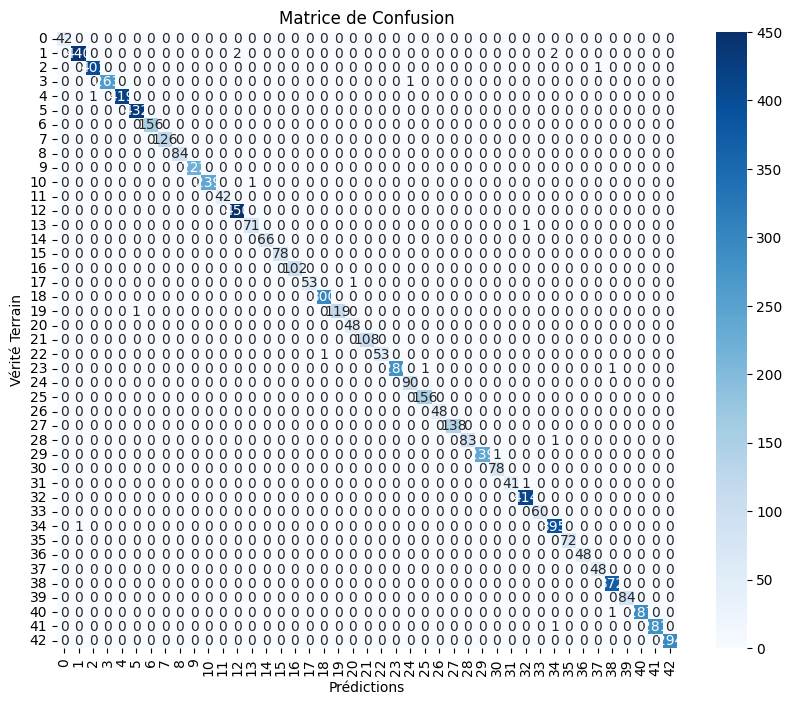

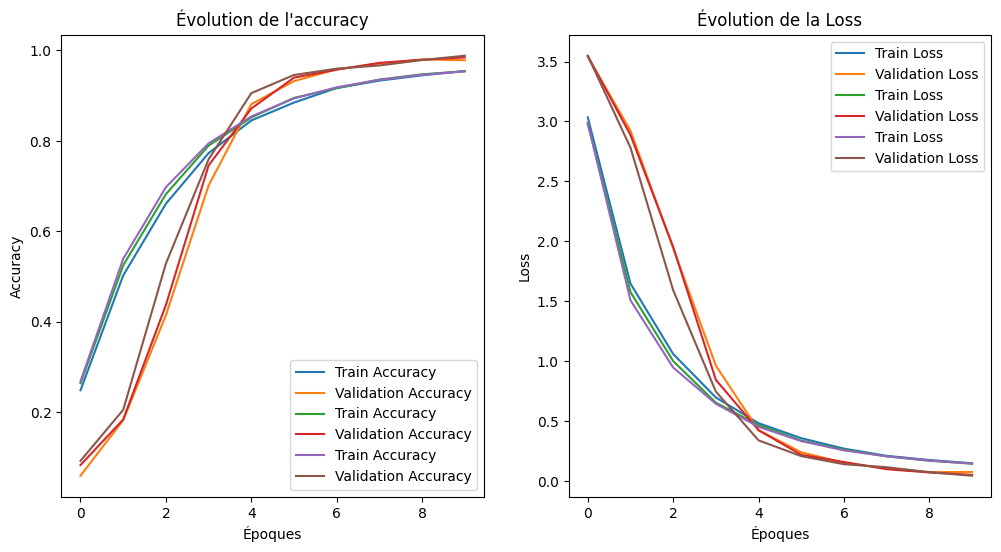

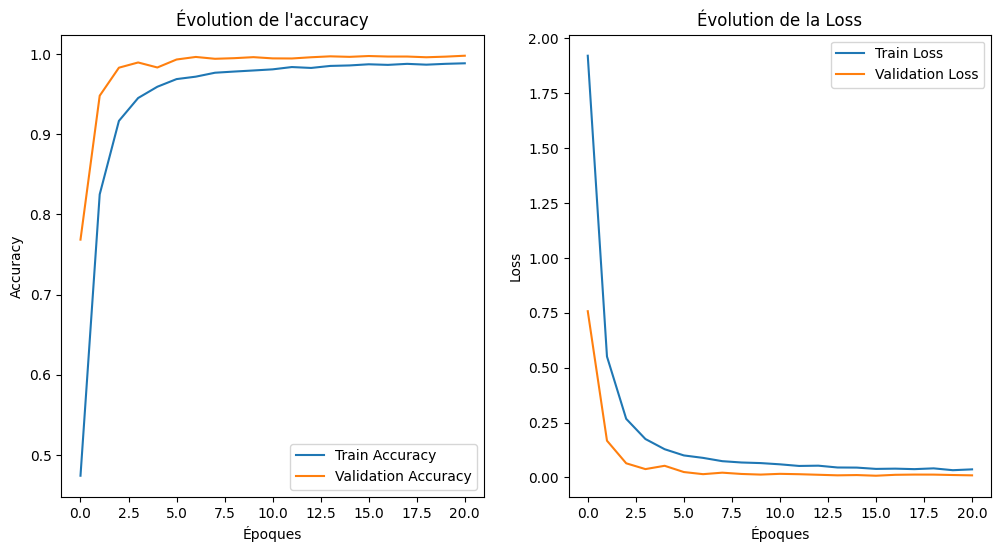

246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9984 - loss: 0.0042
Loss sur le test : 0.0077
Accuracy sur le test : 99.74%


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)                   │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 30, 30, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_36               │ (None, 13, 13, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_36 (Dropout)                 │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_37               │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_37 (Dropout)                 │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 2, 2, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_38               │ (None, 2, 2, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_38 (Dropout)                 │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_7           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_39               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,401,667 (5.35 MB)

 Trainable params: 466,731 (1.78 MB)

 Non-trainable params: 1,472 (5.75 KB)

 Optimizer params: 933,464 (3.56 MB)

In [11]:
X_train, X_test, Y_train, Y_test = data_create()

# Validation croisée
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_results = []
train_histories = []


for train_index, val_index in kfold.split(X_train, np.argmax(Y_train, axis=1)):

    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    Y_train_fold, Y_val_fold = Y_train[train_index], Y_train[val_index]


    model_Swish = create_model_Swish()


    history = model_Swish.fit(X_train_fold, Y_train_fold, validation_data=(X_val_fold, Y_val_fold), epochs=10, batch_size=256, verbose=1)
    train_histories.append(history.history)


    Y_val_pred = model_Swish.predict(X_val_fold)
    val_accuracy = accuracy_score(np.argmax(Y_val_fold, axis=1), np.argmax(Y_val_pred, axis=1))
    cv_results.append(val_accuracy)

# Résultats de la validation croisée
print(f"Précision moyenne en validation croisée : {np.mean(cv_results) * 100:.2f}%")
print(f"Écart-type de la précision : {np.std(cv_results) * 100:.2f}%")

# Création et entraînement du modèle final
model_Swish = create_model_Swish()
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


history_final = model_Swish.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=40,
    batch_size=64,
    verbose=1,
    callbacks=[early_stopping]
)


Y_pred = model_Swish.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)


Y_true = np.argmax(Y_test, axis=1)

#Affichage des performances
test_accuracy = accuracy_score(Y_true, Y_pred_classes)
print(f"Précision sur le jeu de test : {test_accuracy * 100:.2f}%")


cm = confusion_matrix(Y_true, Y_pred_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérité Terrain")
plt.show()


def plot_history(histories):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    for history in histories:
        plt.plot(history['accuracy'], label='Train Accuracy')
        plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Évolution de l\'accuracy')
    plt.xlabel('Époques')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    for history in histories:
        plt.plot(history['loss'], label='Train Loss')
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Évolution de la Loss')
    plt.xlabel('Époques')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_history(train_histories)

# Affichage des courbes d'entraînement pour le modèle final
plot_history([history_final.history])
test_loss, test_acc = model_Swish.evaluate(X_test, Y_test, verbose=1)
print(f"Loss sur le test : {test_loss:.4f}")
print(f"Accuracy sur le test : {test_acc * 100:.2f}%")
model_Swish.summary()
model_Swish.save("model_Swish.h5")

## 6.3 Test du modèle

Nombre d'images test chargées : (12630, 32, 32, 3)
Classes : ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


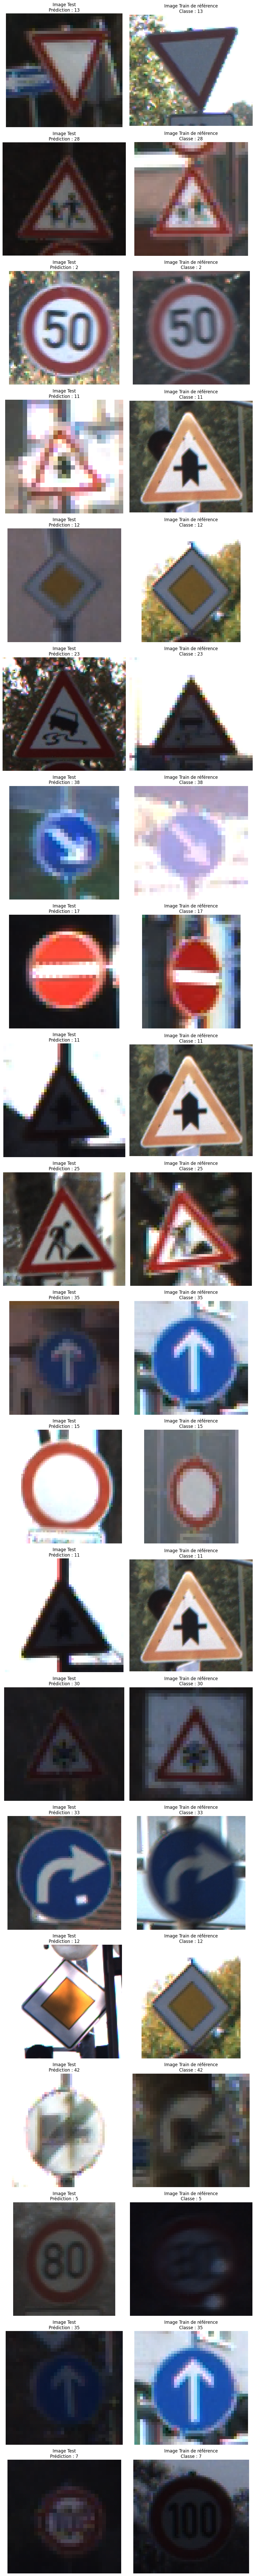

In [12]:


test_dataset_path = "gtsrb_data/Test"   # Dossier Test contenant les images PNG
train_dataset_path = "gtsrb_data/Train" # Dossier Train organisé en sous-dossiers par classe


# Récupérer la liste des images dans Test
test_image_paths = [os.path.join(test_dataset_path, f) for f in os.listdir(test_dataset_path) if f.endswith('.png')]

# Prétraitement des images de Test
def load_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print("Erreur de lecture :", image_path)
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (32, 32))
    image = image.astype('float32') / 255.0
    return image

X_test = []
valid_test_paths = []
for path in test_image_paths:
    img = load_and_preprocess_image(path)
    if img is not None:
        X_test.append(img)
        valid_test_paths.append(path)
X_test = np.array(X_test)

if len(X_test) == 0:
    print("Aucune image test chargée. Vérifie le chemin :", test_dataset_path)
else:
    print("Nombre d'images test chargées :", X_test.shape)

# Récupérer la liste des classes
class_names = sorted([d for d in os.listdir(train_dataset_path) if os.path.isdir(os.path.join(train_dataset_path, d))])
print("Classes :", class_names)

# Réaliser les prédictions avec model_swich
predictions = model_Swish.predict(X_test)
predicted_indices = np.argmax(predictions, axis=1)
predicted_classes = [class_names[idx] for idx in predicted_indices]

# Affichage des résultats
N = min(20, len(valid_test_paths))
fig, axes = plt.subplots(N, 2, figsize=(10, 5 * N))
if N == 1:
    axes = np.expand_dims(axes, axis=0)

for i in range(N):

    test_img_orig = cv2.imread(valid_test_paths[i])
    if test_img_orig is not None:
        test_img_orig = cv2.cvtColor(test_img_orig, cv2.COLOR_BGR2RGB)
    else:
        test_img_orig = np.zeros((32, 32, 3), dtype=np.uint8)


    pred_class = predicted_classes[i]

    # Dans Train, accéder au sous-dossier correspondant et récupérer la première image
    train_class_folder = os.path.join(train_dataset_path, pred_class)
    train_ref_image = None
    if os.path.isdir(train_class_folder):
        train_files = [f for f in os.listdir(train_class_folder) if f.endswith('.png')]
        if len(train_files) > 0:
            train_ref_image_path = os.path.join(train_class_folder, train_files[0])
            train_ref_image = cv2.imread(train_ref_image_path)
            if train_ref_image is not None:
                train_ref_image = cv2.cvtColor(train_ref_image, cv2.COLOR_BGR2RGB)
    if train_ref_image is None:
        train_ref_image = np.zeros((32, 32, 3), dtype=np.uint8)

    # Affichage côte à côte de l'image test et de l'image Train de référence
    axes[i, 0].imshow(test_img_orig)
    axes[i, 0].set_title("Image Test\nPrédiction : " + pred_class)
    axes[i, 0].axis("off")

    axes[i, 1].imshow(train_ref_image)
    axes[i, 1].set_title("Image Train de référence\nClasse : " + pred_class)
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step


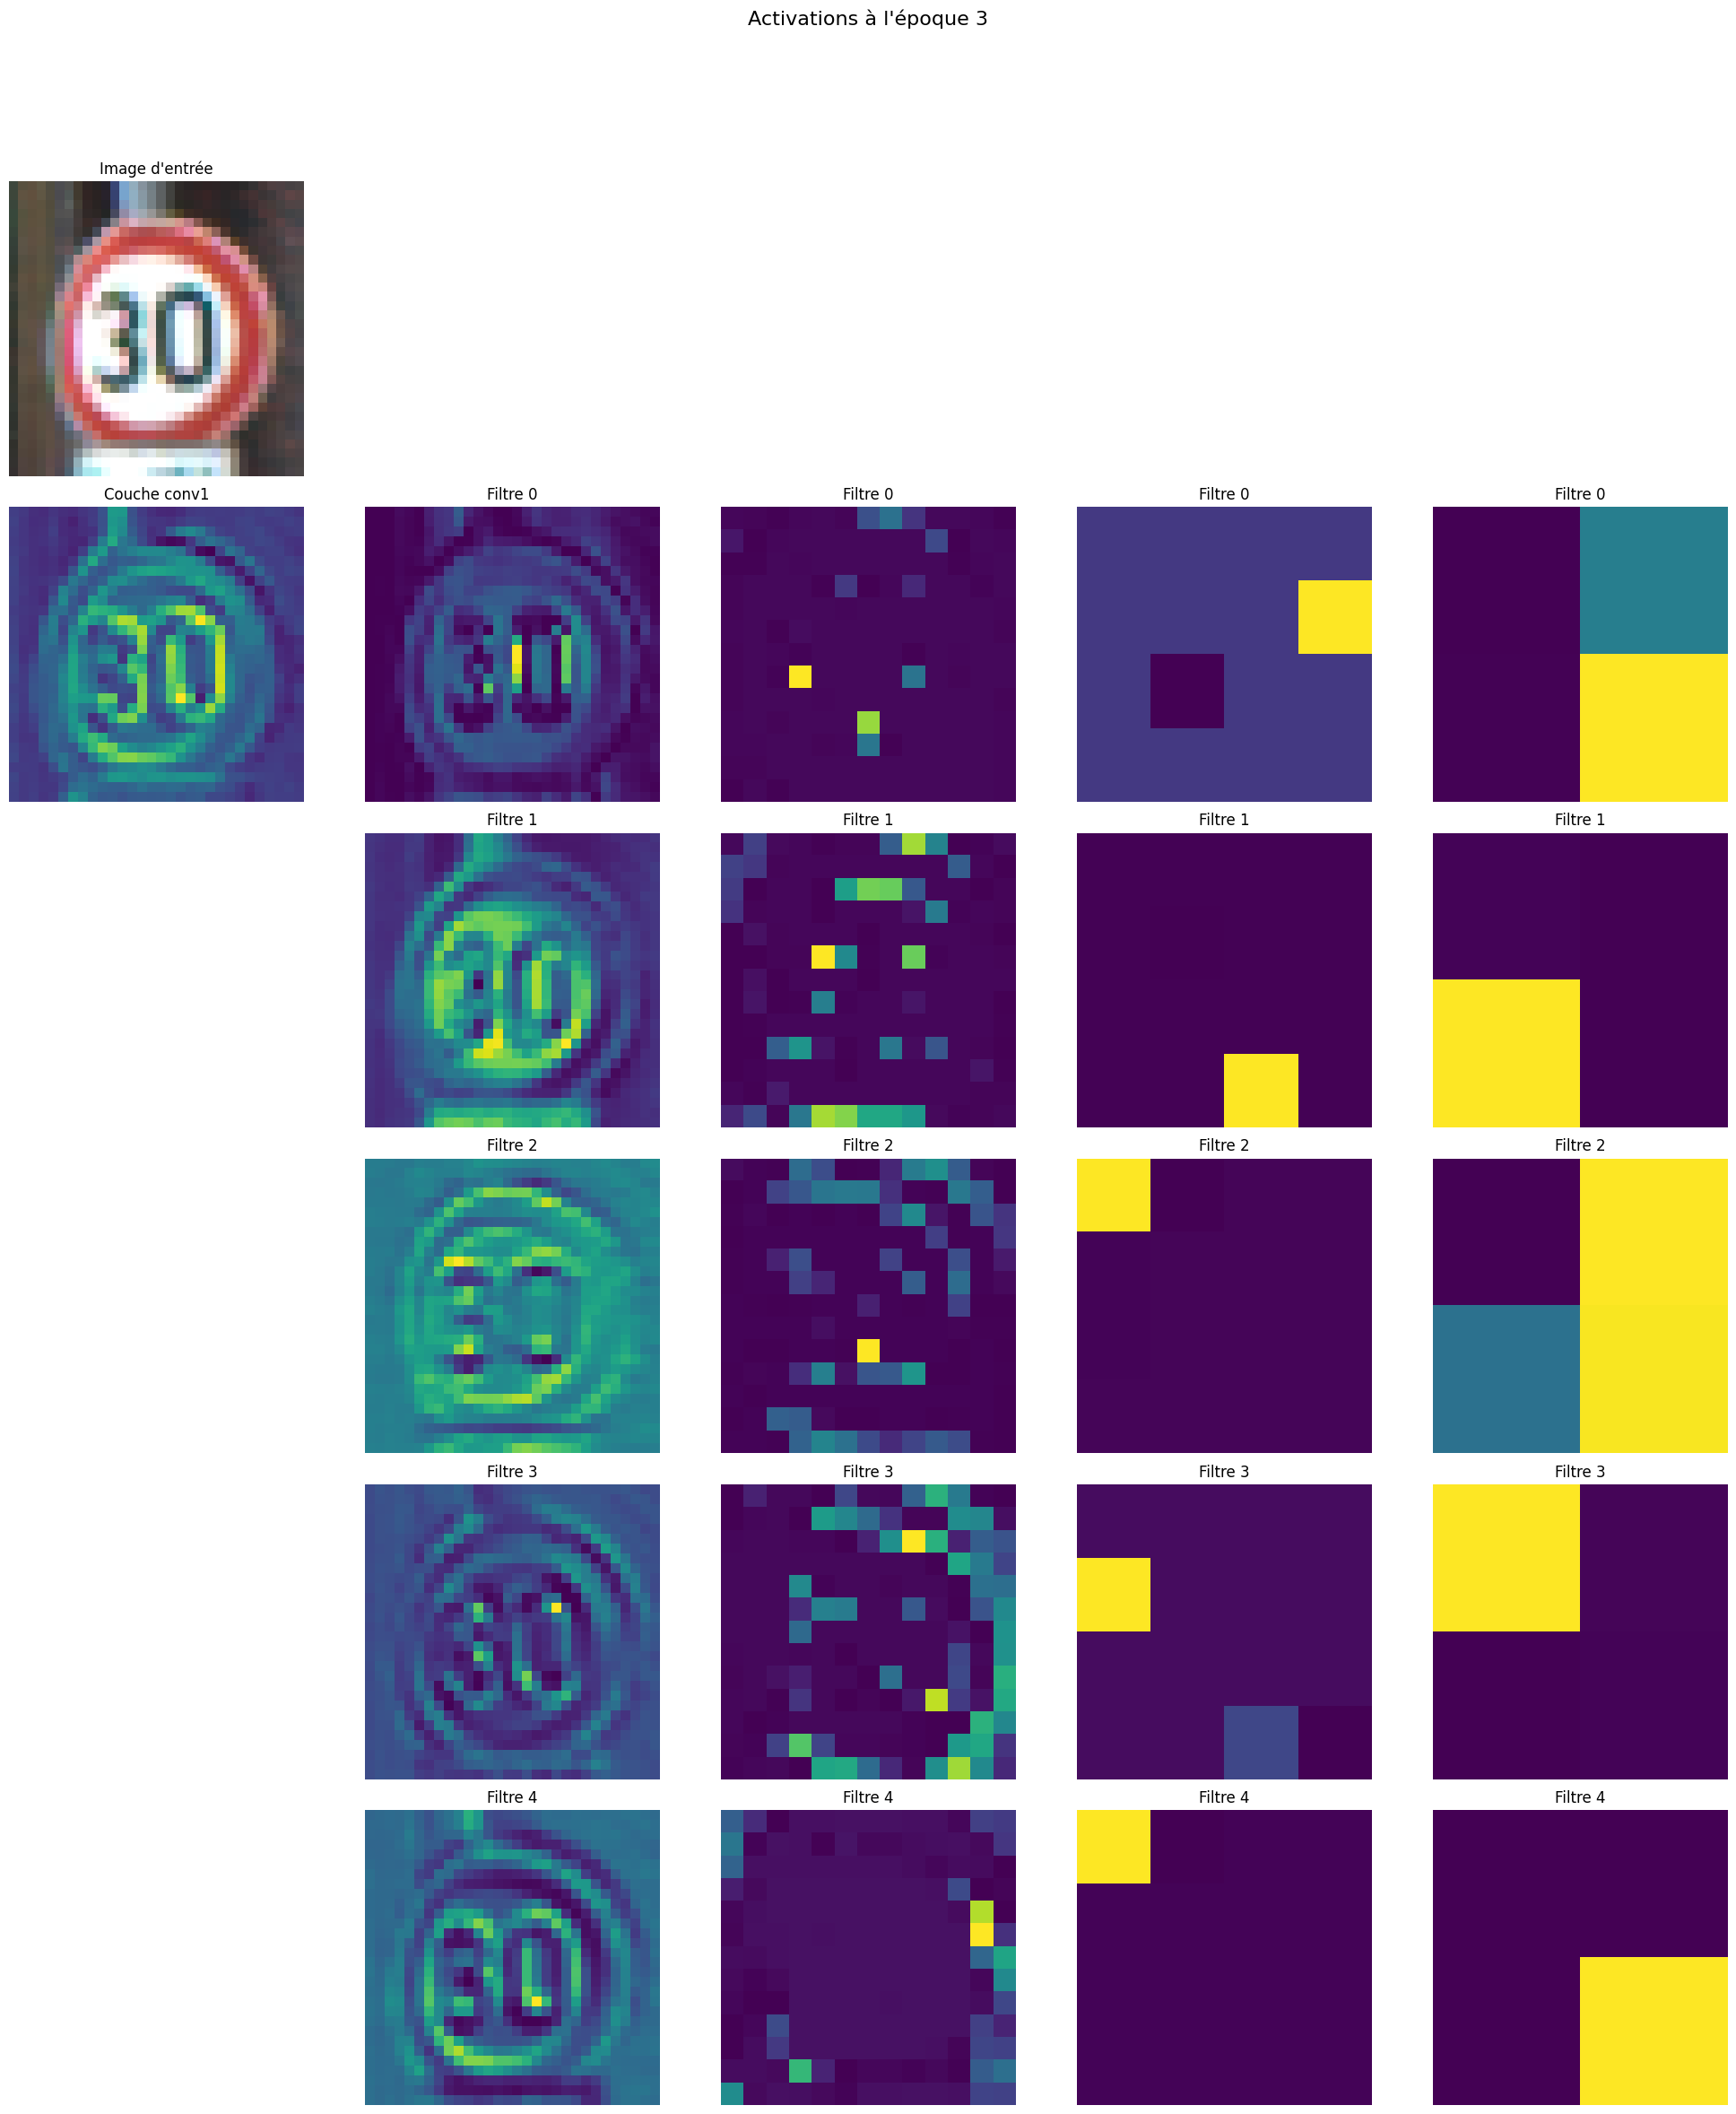

Époque 3 - loss: 0.5000 - accuracy: 0.8500 - val_loss: 0.6000 - val_accuracy: 0.8200


In [13]:
X_train, X_test, Y_train, Y_test = data_create()

def swish(x):
    return x * tf.keras.activations.sigmoid(x)

class ActivationVisualizationCallback(Callback):
    def __init__(self, model, validation_data, layer_names=None, test_image=None):
        super().__init__()
        self.validation_data = validation_data
        self.layer_names = layer_names
        self.test_image = test_image

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 2 == 0:
            clear_output(wait=True)

        layer_outputs = []
        for name in self.layer_names:
            try:
                layer = self.model.get_layer(name)
                layer_outputs.append(layer.output)
            except Exception as e:
                print(f"Couche {name} non trouvée")
                continue

        extraction_model = tf.keras.Model(inputs=self.model.inputs, outputs=layer_outputs)
        test_input = self.test_image if self.test_image is not None else self.validation_data[0][0:1]
        activations = extraction_model.predict(test_input)

        max_filters = 0
        filters_per_layer = []
        for activation in activations:
            if len(activation.shape) == 4:
                n_filters = min(5, activation.shape[-1])
            else:
                n_filters = 1
            filters_per_layer.append(n_filters)
            if n_filters > max_filters:
                max_filters = n_filters

        num_cols = len(activations) + 1
        num_rows = 1 + max_filters

        plt.figure(figsize=(4*num_cols, 4*num_rows))

        plt.subplot(num_rows, num_cols, 1)
        plt.imshow(test_input[0])
        plt.title("Image d'entrée")
        plt.axis('off')

        for i, activation in enumerate(activations):
            col = i + 1
            plt.subplot(num_rows, num_cols, 1* num_cols + col)
            plt.title(f"Couche {self.layer_names[i]}")
            if len(activation.shape) == 4:
                plt.imshow(np.mean(activation[0], axis=-1), cmap='viridis')
            else:
                plt.imshow(activation[0].reshape(8, -1), cmap='viridis')
            plt.axis('off')

        for i, activation in enumerate(activations):
            if len(activation.shape) != 4:
                continue
            n_filters = filters_per_layer[i]
            for j in range(n_filters):
                row = 1 + j
                col = i + 1
                index = row * num_cols + col + 1
                plt.subplot(num_rows, num_cols, index)
                plt.imshow(activation[0, :, :, j], cmap='viridis')
                plt.title(f"Filtre {j}")
                plt.axis('off')

        plt.suptitle(f"Activations à l'époque {epoch+1}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

        print(f"Époque {epoch+1} - loss: {logs['loss']:.4f} - accuracy: {logs['accuracy']:.4f} - val_loss: {logs['val_loss']:.4f} - val_accuracy: {logs['val_accuracy']:.4f}")
        time.sleep(0.5)

def create_model_Swish():
    from tensorflow.keras import layers, models, initializers, optimizers

    model_swish = models.Sequential()

    model_swish.add(layers.Conv2D(32, (3, 3), activation=swish, kernel_initializer=initializers.HeNormal(), input_shape=(32, 32, 3), name='conv1'))
    model_swish.add(layers.BatchNormalization())
    model_swish.add(layers.MaxPooling2D((2, 2)))
    model_swish.add(layers.Dropout(0.25))

    model_swish.add(layers.Conv2D(64, (3, 3), activation=swish, kernel_initializer=initializers.HeNormal(), name='conv2'))
    model_swish.add(layers.BatchNormalization())
    model_swish.add(layers.MaxPooling2D((2, 2)))
    model_swish.add(layers.Dropout(0.25))

    model_swish.add(layers.Conv2D(128, (3, 3), activation=swish, kernel_initializer=initializers.HeNormal(), name='conv3'))
    model_swish.add(layers.BatchNormalization())
    model_swish.add(layers.MaxPooling2D((2, 2)))
    model_swish.add(layers.Dropout(0.25))

    model_swish.add(layers.Conv2D(256, (3, 3), activation=swish, padding='same', kernel_initializer=initializers.HeNormal(), name='conv4'))
    model_swish.add(layers.BatchNormalization())
    model_swish.add(layers.Dropout(0.25))

    model_swish.add(layers.GlobalAveragePooling2D())

    model_swish.add(layers.Dense(256, activation=swish, kernel_initializer=initializers.HeNormal(), name='dense1'))
    model_swish.add(layers.BatchNormalization())
    model_swish.add(layers.Dropout(0.5))

    model_swish.add(layers.Dense(43, activation='softmax', name='output'))

    model_swish.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model_swish

def load_test_image(img_path):
    img = Image.open(img_path)
    img = img.resize((32, 32))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

test_img = load_test_image("/content/gtsrb_data/Test/00001.png")
layer_names = ['conv1', 'conv2', 'conv3', 'conv4']

model = create_model_Swish()

visualization_callback = ActivationVisualizationCallback(
    model=model,
    validation_data=(X_test, Y_test),
    layer_names=layer_names,
    test_image=test_img
)



history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),
    epochs=20,
    batch_size=64,
    callbacks=[
        visualization_callback,
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    verbose=0
)

model.build((None, 32, 32, 3))
simulated_logs = {'loss': 0.5, 'accuracy': 0.85, 'val_loss': 0.6, 'val_accuracy': 0.82}
visualization_callback.set_model(model)

print("Simulation de la visualisation des activations pendant l'entraînement:")
for epoch in range(3):
    visualization_callback.on_epoch_end(epoch, simulated_logs)
    time.sleep(2)

def visualize_trained_model(model, test_img, layer_names):
    layer_outputs = []
    for name in layer_names:
        try:
            layer = model.get_layer(name)
            layer_outputs.append(layer.output)
        except:
            print(f"Couche {name} non trouvée")
            continue

    if not layer_outputs:
        print("Aucune couche trouvée. Affichage des noms de couches disponibles:")
        for layer in model.layers:
            print(f"- {layer.name}")
        return

    extraction_model = tf.keras.Model(inputs=model.inputs, outputs=layer_outputs)
    pred_class = np.argmax(model.predict(test_img))
    activations = extraction_model.predict(test_img)

    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(test_img[0])
    plt.title("Image de test")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, f"Classe prédite: {pred_class}", fontsize=20, ha='center', va='center')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    for i, (activation, name) in enumerate(zip(activations, layer_names)):
        n_filters = min(16, activation.shape[-1])
        n_cols = 4
        n_rows = (n_filters + n_cols - 1) // n_cols

        plt.figure(figsize=(15, 3 + 3 * n_rows))

        plt.subplot(n_rows + 1, n_cols, 1)
        plt.imshow(np.mean(activation[0], axis=-1), cmap='viridis')
        plt.title(f"Moyenne des activations\nCouche {name}")
        plt.axis('off')

        for j in range(n_filters):
            plt.subplot(n_rows + 1, n_cols, j + n_cols + 1)
            plt.imshow(activation[0, :, :, j], cmap='viridis')
            plt.title(f"Filtre {j}")
            plt.axis('off')

        plt.suptitle(f"Activations pour la couche {name}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.show()

# visualize_trained_model(model, test_img, layer_names)

# 7.  Extension du Projet


## 7.1 Import du jeu de données complémentaires

In [16]:
from tensorflow.keras.datasets import cifar10
from keras.utils import to_categorical
X_train, X_test, Y_train, Y_test = data_create()


# Chargement et préparation du jeu de données CIFAR-10
(X_Cifar_train, Y_Cifar_train), (X_Cifar_test, Y_Cifar_test) = cifar10.load_data()

X_Cifar_train = X_Cifar_train.astype('float32') / 255.0
X_Cifar_test = X_Cifar_test.astype('float32') / 255.0

Y_Cifar_binary = np.zeros(len(X_Cifar_train), dtype=int)  # Non-panneau = 0


dataset_path = "gtsrb_data/Train"

# Récupération des classes
classes = sorted(os.listdir(dataset_path))

# Création des listes pour stocker les chemins des images et leurs labels
image_paths = []
class_labels = []

# Chargement des images et des labels
for class_name in classes[:43]:
    class_path = os.path.join(dataset_path, class_name)
    for image_filename in os.listdir(class_path):
        image_path = os.path.join(class_path, image_filename)
        image_paths.append(image_path)
        class_labels.append(class_name)


df = pd.DataFrame({
    'image_path': image_paths,
    'class_label': class_labels
})

# Fonction pour charger et prétraiter les images
def load_and_preprocess_images(image_paths):
    images = []
    for image_path in image_paths:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Erreur de lecture de l'image: {image_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (32, 32))  # Redimensionner
        image = image.astype('float32') / 255.0  # Normaliser
        images.append(image)

    return np.array(images)


X_train = load_and_preprocess_images(df['image_path'].values)

# Définition des labels binaires pour GTSRB (classe positive : 1)
Y_train_binary = np.ones(len(X_train), dtype=int)  # Panneau = 1

# Concaténation des données et des labels
print(f"Forme X_GTSRB : {X_train.shape}, Y_GTSRB : {Y_train_binary.shape}")
print(f"Forme X_CIFAR : {X_Cifar_train.shape}, Y_CIFAR : {Y_Cifar_binary.shape}")


X_combined = np.concatenate((X_train, X_Cifar_train), axis=0)
Y_combined = np.concatenate((Y_train_binary, Y_Cifar_binary), axis=0)

X_train_final, X_test_final, Y_train_final, Y_test_final = train_test_split(
    X_combined, Y_combined, test_size=0.2, random_state=42, stratify=Y_combined
)

print(f"Forme X_train_final : {X_train_final.shape}, Y_train_final : {Y_train_final.shape}")
print(f"Forme X_test_final : {X_test_final.shape}, Y_test_final : {Y_test_final.shape}")


Forme de X (données images) : (39209, 32, 32, 3)
Exemple de labels encodés : [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

## 7.2 Conception du modèle binaire
Classe panneau ou non panneau

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 26s 12ms/step - accuracy: 0.9282 - loss: 0.1830 - val_accuracy: 0.9882 - val_loss: 0.0341
Epoch 2/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9869 - loss: 0.0357 - val_accuracy: 0.9956 - val_loss: 0.0135
Epoch 3/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9923 - loss: 0.0224 - val_accuracy: 0.9965 - val_loss: 0.0124
Epoch 4/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9943 - loss: 0.0178 - val_accuracy: 0.9974 - val_loss: 0.0089
Epoch 5/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9952 - loss: 0.0155 - val_accuracy: 0.9976 - val_loss: 0.0080
Epoch 6/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9927 - loss: 0.0213 - val_accuracy: 0.9982 - val_loss: 0.0058
Epoch 7/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9966 - loss: 0.0102 - val_accuracy: 0.9977 - val_loss: 0.0083
Epoch 8/10
1116/1116 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9967 - loss: 0.010

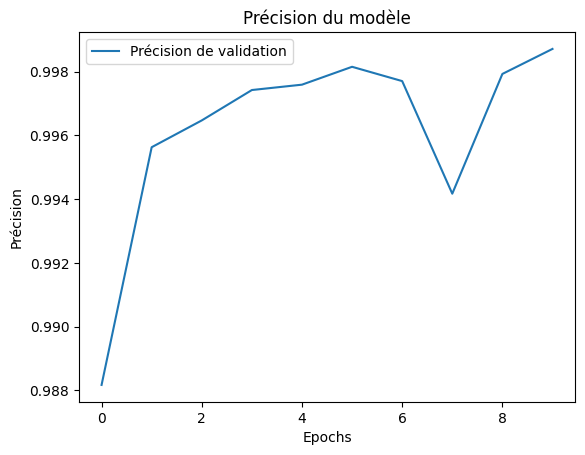

<ipython-input-17-a47018c43ef1>:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = int(predictions[i])


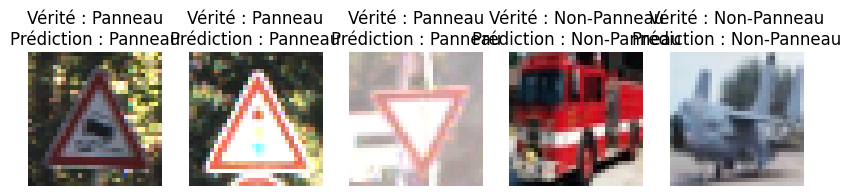

In [17]:
# Création du modèle binaire de classification de panneau ou de non panneau
def create_model_binaire():
    model_binaire = models.Sequential()


    model_binaire.add(layers.Conv2D(32, (3, 3), activation='swish',
                                    kernel_initializer=initializers.HeNormal(),
                                    input_shape=(32, 32, 3)))
    model_binaire.add(layers.BatchNormalization())
    model_binaire.add(layers.MaxPooling2D((2, 2)))
    model_binaire.add(layers.Dropout(0.25))


    model_binaire.add(layers.Conv2D(64, (3, 3), activation='swish',
                                    kernel_initializer=initializers.HeNormal()))
    model_binaire.add(layers.BatchNormalization())
    model_binaire.add(layers.MaxPooling2D((2, 2)))
    model_binaire.add(layers.Dropout(0.25))


    model_binaire.add(layers.Conv2D(128, (3, 3), activation='swish',
                                    kernel_initializer=initializers.HeNormal()))
    model_binaire.add(layers.BatchNormalization())
    model_binaire.add(layers.MaxPooling2D((2, 2)))
    model_binaire.add(layers.Dropout(0.25))


    model_binaire.add(layers.Conv2D(256, (3, 3), activation='swish', padding='same',
                                    kernel_initializer=initializers.HeNormal()))
    model_binaire.add(layers.BatchNormalization())
    model_binaire.add(layers.Dropout(0.25))


    model_binaire.add(layers.GlobalAveragePooling2D())


    model_binaire.add(layers.Dense(256, activation='swish',
                                    kernel_initializer=initializers.HeNormal()))
    model_binaire.add(layers.BatchNormalization())
    model_binaire.add(layers.Dropout(0.5))

    model_binaire.add(layers.Dense(1, activation='sigmoid'))

    model_binaire.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                          loss='binary_crossentropy',  # Classification binaire
                          metrics=['accuracy'])

    return model_binaire

# Création et entraînement du modèle
model_binaire = create_model_binaire()


history_final = model_binaire.fit(
    X_train_final, Y_train_final,
    validation_data=(X_test_final, Y_test_final),
    epochs=10,
    batch_size=64,
    verbose=1,
)




Y_pred = model_binaire.predict(X_test_final)
Y_pred_binary = (Y_pred > 0.5).astype(int)  # Seuil de classification à 0.5 pour convertir en 0 ou 1

#  Affichage des performances
accuracy = accuracy_score(Y_test_final, Y_pred_binary)
print(f"Précision sur le jeu de test : {accuracy:.4f}")
print("Rapport de classification :")
print(classification_report(Y_test_final, Y_pred_binary))

plt.plot(history_final.history['val_accuracy'], label='Précision de validation')
plt.title('Précision du modèle')
plt.xlabel('Epochs')
plt.ylabel('Précision')
plt.legend()
plt.show()

# Affichage des prédictions et des vérités
def display_predictions(images, labels, predictions, class_names, n=5):
    plt.figure(figsize=(10, 5))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])

        label = int(labels[i])
        prediction = int(predictions[i])

        plt.title(f"Vérité : {class_names[label]}\nPrédiction : {'Panneau' if prediction == 1 else 'Non-Panneau'}")
        plt.axis('off')
    plt.show()

display_predictions(X_test_final, Y_test_final, Y_pred_binary, ['Non-Panneau', 'Panneau'])

model_binaire.save('model_binaire.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 664ms/step
Probabilité que ce soit un panneau : 1.0000
L'image est un panneau.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 586ms/step
Classe prédite par le modèle Switch : 15


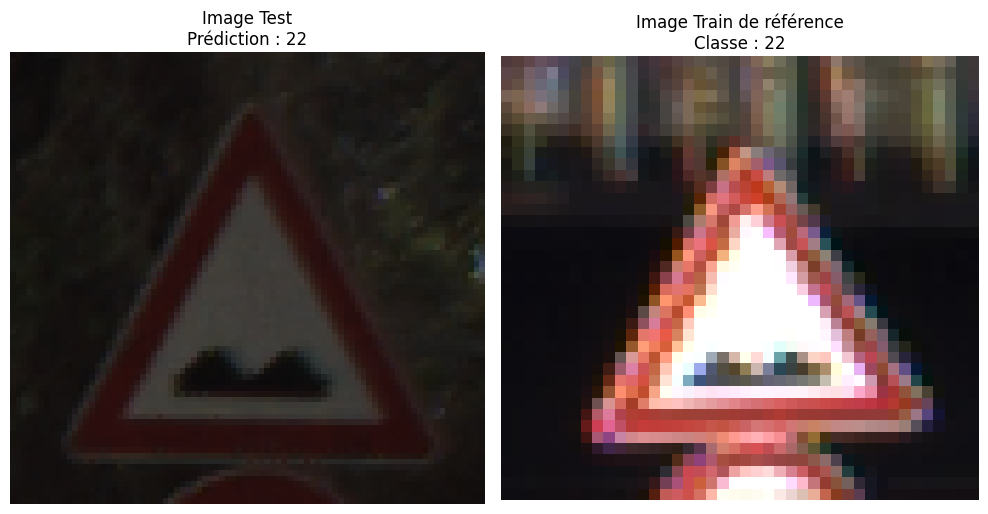

In [18]:
# Chargement des modèles
model_swich = load_model('model_Swish.h5')  # Modèle de classification
model_binaire = load_model('model_binaire.h5')  # Modèle binaire


train_dataset_path = "gtsrb_data/Train"

# Prétraitement de l'image à tester
def preprocess_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (32, 32))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    return img

# Fonction pour prédire si c'est un panneau ou non
def predict_is_panneau(img):
    img_preprocessed = preprocess_image(img)
    return model_binaire.predict(img_preprocessed)[0][0]

# Fonction pour classifier l'image si c'est un panneau
def classify_panneau(img):
    img_preprocessed = preprocess_image(img)
    prediction_swich = model_swich.predict(img_preprocessed)
    predicted_class = np.argmax(prediction_swich, axis=1)
    return predicted_class[0]

#  Image test
uploaded_image_path = 'gtsrb_data/test/00088.png'
img = cv2.imread(uploaded_image_path)


is_panneau = predict_is_panneau(img)
print(f"Probabilité que ce soit un panneau : {is_panneau:.4f}")

if is_panneau > 0.5:
    print("L'image est un panneau.")

    predicted_class = classify_panneau(img)
    print(f"Classe prédite par le modèle Switch : {predicted_class}")


    test_img_orig = cv2.imread(uploaded_image_path)
    test_img_orig = cv2.cvtColor(test_img_orig, cv2.COLOR_BGR2RGB) if test_img_orig is not None else np.zeros((32, 32, 3), dtype=np.uint8)


    class_names = sorted([d for d in os.listdir(train_dataset_path) if os.path.isdir(os.path.join(train_dataset_path, d))])
    pred_class = class_names[predicted_class]  # Classe prédite
    train_class_folder = os.path.join(train_dataset_path, pred_class)
    train_ref_image = None

    if os.path.isdir(train_class_folder):
        train_files = [f for f in os.listdir(train_class_folder) if f.endswith('.png')]
        if train_files:
            train_ref_image_path = os.path.join(train_class_folder, train_files[0])
            train_ref_image = cv2.imread(train_ref_image_path)
            train_ref_image = cv2.cvtColor(train_ref_image, cv2.COLOR_BGR2RGB) if train_ref_image is not None else np.zeros((32, 32, 3), dtype=np.uint8)

    # Affichage des résultats
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(test_img_orig)
    axes[0].set_title(f"Image Test\nPrédiction : {pred_class}")
    axes[0].axis("off")

    axes[1].imshow(train_ref_image)
    axes[1].set_title(f"Image Train de référence\nClasse : {pred_class}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

else:
    print("L'image n'est pas un panneau.")
